## Runtime Comparison

**Author:** Alex Michels

In this notebook we will compare the runtime of our clustering algorithm for travel-time analysis against analyzing each hospital seperately.

First, we need to load some packages for our analysis:

In [1]:
import datetime
from glob import glob
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Each method had a "Part 1" and "Part 2". 

* Part 1 perfomed the clustering (or not) and then submitted each hospital/cluster as a seperate job, pausing for 1 second between jobs. 
* The jobs submitted by Part 1 are the "Part 2" jobs. They performed the analysis (travel-time catchment) for the hospital or region assigned to them by Part 1. At the end of each Part 2 job, the job records it's index and runtime in seconds in a file

The "-1" region index gives the time in seconds recorded by SLURM for the "Part 1"s (manually entered from SLURM output) and the rest are the time in seconds (recorded by the Python script). The data is at the path `/data/runtime`. The files ending with "NM" stands for "no merge" and the files ending with "XXG" have the records when applying SPASTC for XX gigabytes memory limit for the computation (so the SPASTC partitioning used XX/2). We ran each method 5 times, let's dig into the data:

In [2]:
time_path = "../data/runtime/"
runtime_file = "Par_Timings-{}-*.csv"
runtime_codes = ["20G", "26G", "32G", "40G", "48G", "56G", "64G", "72G", "NM"]
runtime_globs = [time_path + runtime_file.format(x) for x in runtime_codes]
print(runtime_globs)

['../data/runtime/Par_Timings-20G-*.csv', '../data/runtime/Par_Timings-26G-*.csv', '../data/runtime/Par_Timings-32G-*.csv', '../data/runtime/Par_Timings-40G-*.csv', '../data/runtime/Par_Timings-48G-*.csv', '../data/runtime/Par_Timings-56G-*.csv', '../data/runtime/Par_Timings-64G-*.csv', '../data/runtime/Par_Timings-72G-*.csv', '../data/runtime/Par_Timings-NM-*.csv']


<hr id="comparison">

## Analyzing Runtimes

Now that we have specified the paths, let's load the SPASTC data:

In [3]:
csvs = {}
for code, pattern in zip(runtime_codes, runtime_globs):
    print(pattern)
    _files_to_load = glob(pattern)
    print(f"We have {len(_files_to_load)} files for code {code}")
    csvs[code] = []
    for _file in _files_to_load:
        df = pd.read_csv(_file)
        csvs[code].append(df)

../data/runtime/Par_Timings-20G-*.csv
We have 10 files for code 20G
../data/runtime/Par_Timings-26G-*.csv
We have 10 files for code 26G
../data/runtime/Par_Timings-32G-*.csv
We have 10 files for code 32G
../data/runtime/Par_Timings-40G-*.csv
We have 10 files for code 40G
../data/runtime/Par_Timings-48G-*.csv
We have 10 files for code 48G
../data/runtime/Par_Timings-56G-*.csv
We have 10 files for code 56G
../data/runtime/Par_Timings-64G-*.csv
We have 10 files for code 64G
../data/runtime/Par_Timings-72G-*.csv
We have 10 files for code 72G
../data/runtime/Par_Timings-NM-*.csv
We have 10 files for code NM


So we have a list of Dataframes. Let's preview one of them:

In [4]:
csvs[code][0].head()

,REGION_INDEX,TIME,STARTEND
0,160,60.374446,1.676503e+09
1,40,72.040859,1.676503e+09
2,20,75.468920,1.676503e+09
3,120,87.079167,1.676503e+09
4,80,93.712496,1.676503e+09


To know if we were able to speed up or not, we need to calculate the "no merge" (NM) average runtime:

In [5]:
no_merge_avg = np.mean([sum(df['TIME']) for df in csvs["NM"]])
print(datetime.timedelta(seconds=no_merge_avg))

23 days, 18:40:50.457408


Using that information, we can now calculate a variety of summary statistics:

* Mean Part 1 - the average time for the clustering/job submission step.
* Mean Part 2 - the average time for the travel time calculation step.
* Mean Total - the average total computing time for the method.
* STD Total - the standard deviation for the total computing time for the method.
* Waiting Time - the maximum Part 1 and Part 2. This is the worst-case waiting time to get results back if you could run infinite (or at least 7438) jobs at once.
* Speed Up - the no merge average computing time divided by the average computing time for the method.

In [6]:
table_string = "|Method|Mean Job Submission|Mean Travel Analysis|Mean Total|STD Total|Turnaround Time|Speed Up|\n|-|-|-|-|-|-|-|\n"
for key, val in csvs.items():
    table_string += f"|{key}|"
    mean_part_1 = round(np.mean([df.loc[df['REGION_INDEX']==-1, 'TIME'].values[0] for df in val]))
    table_string += f"{datetime.timedelta(seconds=mean_part_1)}|"
    mean_part_2 = round(np.mean([sum(df.loc[df['REGION_INDEX']>-1, 'TIME']) for df in val]))
    mean_total = round(np.mean([sum(df['TIME']) for df in val]))
    table_string += f"{datetime.timedelta(seconds=mean_part_2)}|"
    table_string += f"{datetime.timedelta(seconds=mean_total)}|"
    std_total = round(np.std([sum(df['TIME']) for df in val]))
    table_string += f"{datetime.timedelta(seconds=std_total)}|"
    max_waiting_time = round(max([df.loc[df['REGION_INDEX']==-1, 'TIME'].values[0] for df in val]) + max([max(df.loc[df['REGION_INDEX']>-1, 'TIME']) for df in val]))
    table_string += f"{datetime.timedelta(seconds=max_waiting_time)}|"
    table_string += f"{no_merge_avg/mean_total:.2f}x|"
    table_string += "\n"

display(Markdown(table_string))

|Method|Mean Job Submission|Mean Travel Analysis|Mean Total|STD Total|Turnaround Time|Speed Up|
|-|-|-|-|-|-|-|
|20G|0:07:38|15:16:10|15:23:49|0:44:27|0:38:17|37.06x|
|26G|0:07:36|14:09:17|14:16:53|0:45:09|0:57:35|39.96x|
|32G|0:07:09|11:32:36|11:39:45|0:50:13|0:58:35|48.93x|
|40G|0:06:56|11:23:34|11:30:30|0:47:18|0:56:40|49.59x|
|48G|0:06:25|10:52:46|10:59:11|0:16:47|1:03:11|51.94x|
|56G|0:06:39|11:32:41|11:39:20|0:59:20|1:13:56|48.96x|
|64G|0:07:01|11:12:26|11:19:27|0:19:13|1:23:30|50.39x|
|72G|0:06:52|12:28:06|12:34:58|1:01:04|1:56:54|45.35x|
|NM|0:08:00|23 days, 18:32:51|23 days, 18:40:50|1 day, 5:05:26|0:21:59|1.00x|


Let's make a line graph to illustrate the average computing times with standard deviation error bars. First, let's collect the information we need:

In [7]:
gbs = [int(code[:-1]) for code in runtime_codes[:-1]]
means = [round(np.mean([sum(df['TIME']) for df in val])) / 3600.0 for key, val in csvs.items()][:-1]
stds = [round(np.std([sum(df['TIME']) for df in val])) / 3600.0 for key, val in csvs.items()][:-1]
gbs, means, stds

([20, 26, 32, 40, 48, 56, 64, 72],
 [15.396944444444445,
  14.28138888888889,
  11.6625,
  11.508333333333333,
  10.98638888888889,
  11.655555555555555,
  11.324166666666667,
  12.582777777777778],
 [0.7408333333333333,
  0.7525,
  0.8369444444444445,
  0.7883333333333333,
  0.2797222222222222,
  0.9888888888888889,
  0.3202777777777778,
  1.0177777777777777])

Then, we can plot it:

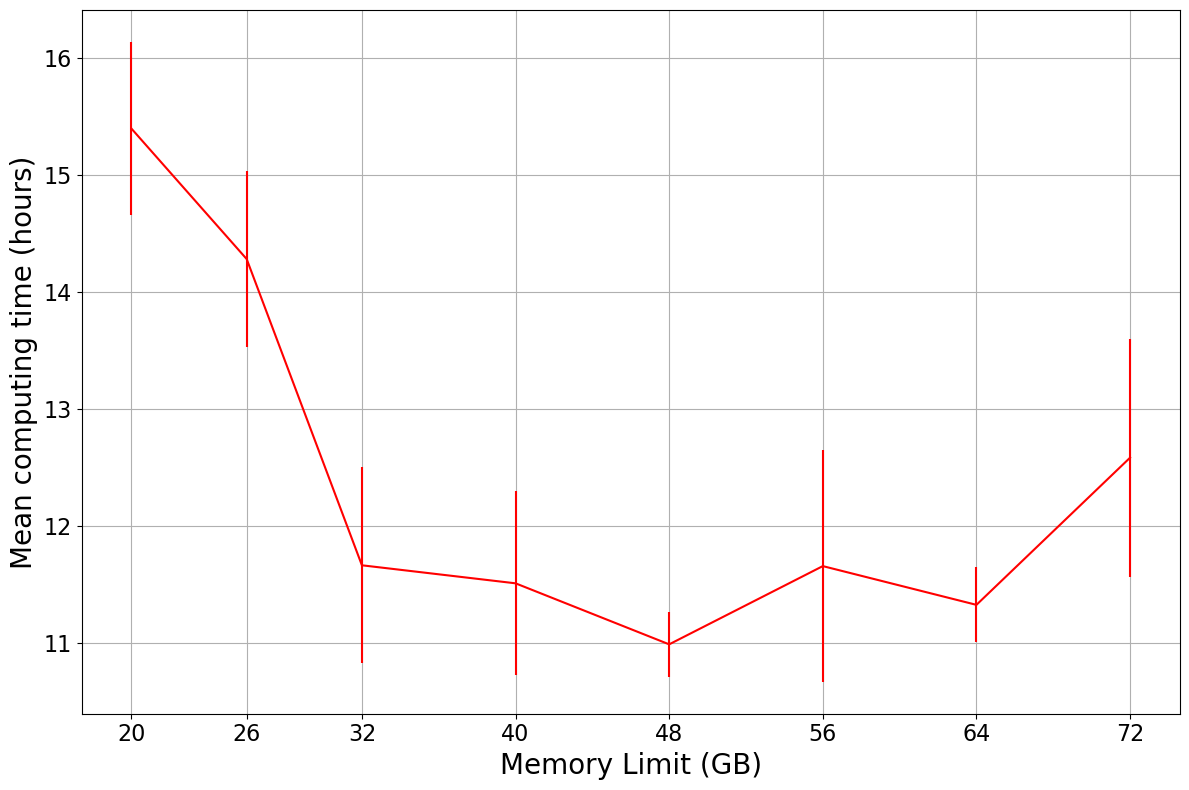

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
fontsize = 20
plt.errorbar(gbs, means, yerr=stds, color='red')
plt.xlabel("Memory Limit (GB)", fontsize=fontsize)
plt.xticks(gbs, fontsize=fontsize-4)
plt.ylabel("Mean computing time (hours)", fontsize=fontsize)
plt.yticks(fontsize=fontsize-4)
ax.grid('on')
plt.tight_layout()
plt.savefig("../img/Runtimes.jpg")
plt.show()